In [1]:
from tensorflow.keras import layers, models, backend, utils, metrics, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics as skmetrics
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import errno
import scipy
from scipy import ndimage
import imageio


In [6]:
DIR_PREFIX  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/'

def load_dataset(path):
    dataset = {"image_path":[],"img_status":[],"where":[]}
    for status in os.listdir(path):
        for image in glob.glob(path+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append("train")
    dataset = pd.DataFrame(dataset)
    dataset.value_counts("img_status")
    real = dataset.value_counts("img_status")[1]
    fake = dataset.value_counts("img_status")[0]

    print(f"Real: {real},\nFake: {fake}\n")
    sns.countplot(dataset["img_status"])
    plt.show()
    return dataset

def view_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        plt.title(dataset.loc[random, "img_status"], size = 10) 
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
def predict(img_path):
    input_arr = []
    count = 0
    image = preprocessing.image.load_img(
        img_path, grayscale=False, color_mode="rgb", target_size=(224, 224, 3)
    )
    i = preprocessing.image.img_to_array(image)
    input_arr = np.array([i])
    predictions = model.predict(input_arr)
    return predictions[0]

def predict_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        predicted = predict(dataset.loc[random,"image_path"]);
        plt.title(f"{dataset.loc[random, 'img_status']} accuracy: {predicted}", size = 10) 
        plt.xticks([])
        plt.yticks([])
    

def rotate_image(dir_name='train', deg=35):
    try:
        os.mkdir('./output/'+dir_name)
        os.mkdir('./output/'+dir_name+'/fake')
        os.mkdir('./output/'+dir_name+'/real')
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    i = 0
    print('data processed for '+dir_name)
    for filename in os.listdir(DIR_PREFIX+dir_name):
        f = os.path.join(DIR_PREFIX+dir_name, filename)
        # checking if it is a file
        if os.path.isdir(f):
            rotate_image(dir_name+'/'+filename, deg)
        else:
            i = i+1
            with Image.open(f) as im:
                im = im.rotate(deg)
                im.save(f.replace(DIR_PREFIX,'./output/'))
            print(i, end='\r')
            
try:
    os.mkdir('./output')
except OSError as exc:
    pass

In [ ]:
path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/train'
train_dataset = load_dataset(path)

In [ ]:
view_dataset(train_dataset)

In [22]:
rotate_image('valid', 45)
rotate_image('train', 45)


data processed for valid
data processed for valid/fake
data processed for valid/real


Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


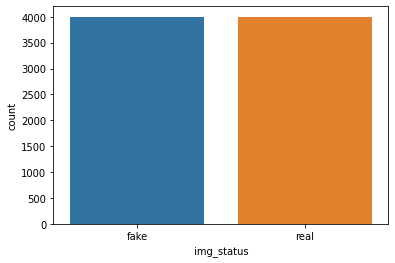

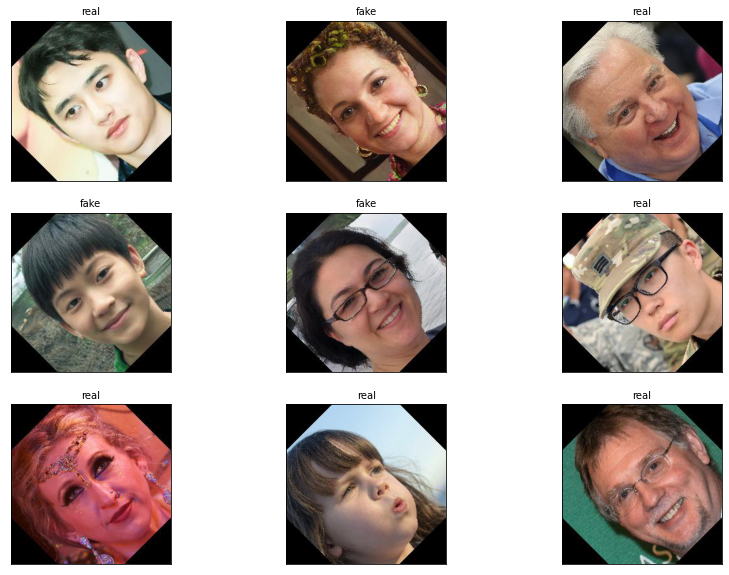

In [17]:
path  = './output/train'
train_dataset_preprocessed = load_dataset(path)
view_dataset(train_dataset_preprocessed)

In [23]:
base_path = './output/'
train_flow = preprocessing.image_dataset_from_directory(
    base_path + 'train/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
test_flow = preprocessing.image_dataset_from_directory(
    '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
valid_flow = preprocessing.image_dataset_from_directory(
    base_path + 'valid/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
train_flow.class_names

Found 8000 files belonging to 2 classes.
Found 3587 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


['fake', 'real']

In [24]:
model = models.Sequential()

model.add(
    layers.Conv2D(32, (3, 3),activation='relu', input_shape=(224, 224, 3))
)

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# output node 1 means prediction in 0 -- 1 and decimals
# output node 2 means predication of 0 or 1 no decimals
model.summary()

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = [
        'accuracy'
    ]
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 256)      

In [25]:
train_steps = 4000//64
valid_steps = 4000//64

hist = model.fit(
    train_flow,
    epochs=10,
    validation_data=valid_flow,
    batch_size=64
)

Epoch 1/10
125/125 [==============================] - 15s 114ms/step - loss: 1.4287 - accuracy: 0.5204 - val_loss: 0.6889 - val_accuracy: 0.5730
Epoch 2/10
125/125 [==============================] - 15s 117ms/step - loss: 0.6963 - accuracy: 0.5266 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/10
125/125 [==============================] - 14s 112ms/step - loss: 0.6761 - accuracy: 0.5691 - val_loss: 0.6657 - val_accuracy: 0.6070
Epoch 4/10
125/125 [==============================] - 15s 117ms/step - loss: 0.6560 - accuracy: 0.6226 - val_loss: 0.6806 - val_accuracy: 0.5760
Epoch 5/10
125/125 [==============================] - 14s 107ms/step - loss: 0.6228 - accuracy: 0.6546 - val_loss: 0.6232 - val_accuracy: 0.6595
Epoch 6/10
125/125 [==============================] - 14s 112ms/step - loss: 0.6023 - accuracy: 0.6768 - val_loss: 0.6081 - val_accuracy: 0.6680
Epoch 7/10
125/125 [==============================] - 14s 111ms/step - loss: 0.5631 - accuracy: 0.7119 - val_loss: 0.5825 - val_ac

In [26]:
y_pred = model.predict(test_flow)
y_pred

array([[0.9429279 ],
       [0.92603487],
       [0.74384964],
       ...,
       [0.8240187 ],
       [0.97399104],
       [0.7857396 ]], dtype=float32)

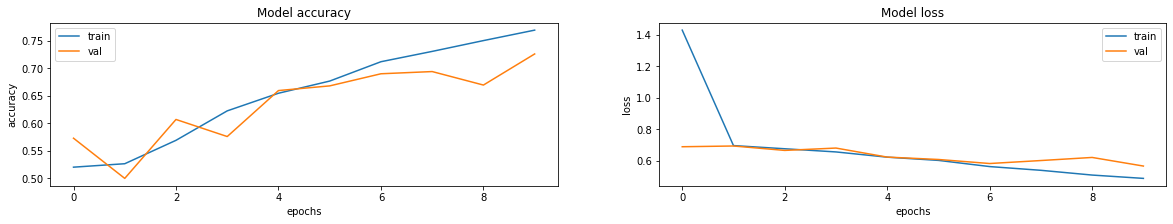

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
# path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test'
# test_dataset = load_dataset(path)
# predict_dataset(test_dataset)